# Import libaries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input as ef_pre
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2025-08-21 15:28:23.435891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset and augmentation

In [2]:
BASE_DIR   = "Malaria-Detection/Dataset"   # Dataset/{train,val,test}/{Parasitized,Uninfected}
IMG_SIZE   = (224, 224)
BATCH_SIZE = 64
SEED       = 42
AUTOTUNE   = tf.data.AUTOTUNE
PREPROC = ef_pre

# ====== Dataset loaders ======
train_gen = tf.keras.utils.image_dataset_from_directory(
    directory = f"{BASE_DIR}/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_gen = tf.keras.utils.image_dataset_from_directory(
    directory = f"{BASE_DIR}/val",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    directory = f"{BASE_DIR}/test",
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ====== Preprocessing pipeline ======
# augment chỉ áp dụng cho train
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# map pipeline: augment (chỉ train) + preprocess_input
train_gen = (
    train_gen
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (PREPROC(x), y), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

val_gen = val_gen.map(lambda x, y: (PREPROC(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_gen = test_gen.map(lambda x, y: (PREPROC(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

Found 22046 files belonging to 2 classes.


I0000 00:00:1755790108.265944   83152 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22162 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:61:00.0, compute capability: 8.9


Found 2756 files belonging to 2 classes.
Found 2756 files belonging to 2 classes.


# Build model

In [3]:
base = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base.trainable = False  # warm-up

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Train model

In [4]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7),
]

# Warm-up
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


2025-08-21 15:28:51.356523: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d25c0002ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-21 15:28:51.356584: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-08-21 15:28:51.760282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-21 15:29:08.933143: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
I0000 00:00:1755790168.424653   84072 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


345/345 ━━━━━━━━━━━━━━━━━━━━ 124s 199ms/step - acc: 0.8748 - auc: 0.9474 - loss: 0.3622 - val_acc: 0.9278 - val_auc: 0.9768 - val_loss: 0.2759 - learning_rate: 0.0010
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - acc: 0.9201 - auc: 0.9713 - loss: 0.2895 - val_acc: 0.9398 - val_auc: 0.9800 - val_loss: 0.2612 - learning_rate: 0.0010
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - acc: 0.9245 - auc: 0.9746 - loss: 0.2792 - val_acc: 0.9423 - val_auc: 0.9810 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - acc: 0.9281 - auc: 0.9759 - loss: 0.2739 - val_acc: 0.9456 - val_auc: 0.9821 - val_loss: 0.2568 - learning_rate: 0.0010
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - acc: 0.9304 - auc: 0.9766 - loss: 0.2711 - val_acc: 0.9409 - val_auc: 0.9823 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - acc: 0.9305 - auc: 0.9767 - loss: 0.2703 - val_acc: 0.9427 - val_auc: 0.9

In [5]:
# Fine-tune
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)

model.fit(train_gen, epochs=150, validation_data=val_gen, callbacks=callbacks)

Epoch 1/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 137s 204ms/step - acc: 0.9280 - auc: 0.9726 - loss: 0.2848 - val_acc: 0.9470 - val_auc: 0.9838 - val_loss: 0.2451 - learning_rate: 1.0000e-05
Epoch 2/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - acc: 0.9345 - auc: 0.9774 - loss: 0.2694 - val_acc: 0.9485 - val_auc: 0.9853 - val_loss: 0.2382 - learning_rate: 1.0000e-05
Epoch 3/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - acc: 0.9369 - auc: 0.9777 - loss: 0.2652 - val_acc: 0.9517 - val_auc: 0.9862 - val_loss: 0.2327 - learning_rate: 1.0000e-05
Epoch 4/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - acc: 0.9400 - auc: 0.9798 - loss: 0.2567 - val_acc: 0.9517 - val_auc: 0.9868 - val_loss: 0.2298 - learning_rate: 1.0000e-05
Epoch 5/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - acc: 0.9405 - auc: 0.9808 - loss: 0.2536 - val_acc: 0.9507 - val_auc: 0.9873 - val_loss: 0.2261 - learning_rate: 1.0000e-05
Epoch 6/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - acc: 0.9433 - auc: 0.9828 - loss: 0.

# Evaluate

In [8]:
test_loss, test_acc, test_auc = model.evaluate(test_gen, verbose=0)
print(f"Test loss: {test_loss:.4f} | acc: {test_acc:.4f} | auc: {test_auc:.4f}")

Test loss: 0.1939 | acc: 0.9619 | auc: 0.9942


# Confusion matrix

2025-08-21 16:19:15.904281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step


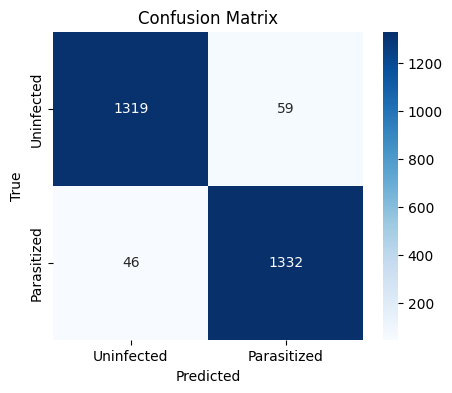

              precision    recall  f1-score   support

  Uninfected       0.97      0.96      0.96      1378
 Parasitized       0.96      0.97      0.96      1378

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



In [9]:
y_true = np.concatenate([y for x, y in test_gen], axis=0)              # ground truth
y_pred = model.predict(test_gen)                                       # dự đoán xác suất
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()              # chuyển sang 0/1

cm = confusion_matrix(y_true, y_pred_classes)
labels = ["Uninfected", "Parasitized"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=labels))